# Використання TensorFlow для розпізнання власного зображення

In [1]:
# Імпортування загальних бібліотек
import os
import numpy as np

# Візуалізація
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
# TensorFlow імпорт

import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import EarlyStopping

from tensorflow.keras.preprocessing import image

## Встановлення параметрів фото

In [28]:
# Тестовий датасет встанвлювався вручну, через малий обсяг даних
train_image_folder = os.path.join('datasets', 'face_dataset_train_images')
test_image_folder = os.path.join('datasets', 'face_dataset_test_images')
img_height, img_width = 250, 150  # size of images
num_classes = 2  # me - not_me

# Тренувальний обсяг
validation_ratio = 0.25  # 25% для перевірки
batch_size = 16

AUTOTUNE = tf.data.AUTOTUNE

## Робота з датасетом

In [29]:
# тренувальний та валідаційні датасети
train_ds = keras.preprocessing.image_dataset_from_directory(
    train_image_folder,
    validation_split=validation_ratio,
    subset="training",
    seed=42,
    image_size=(img_height, img_width),
    label_mode='categorical',
    batch_size=batch_size,
    shuffle=True)

val_ds = keras.preprocessing.image_dataset_from_directory(
    train_image_folder,
    validation_split=validation_ratio,
    subset="validation",
    seed=42,
    image_size=(img_height, img_width),
    batch_size=batch_size,
    label_mode='categorical',
    shuffle=True)

Found 168 files belonging to 2 classes.
Using 126 files for training.
Found 168 files belonging to 2 classes.
Using 42 files for validation.


In [30]:
# тестові дані
test_ds = keras.preprocessing.image_dataset_from_directory(
    test_image_folder,
    image_size=(img_height, img_width),
    label_mode='categorical',
    shuffle=False)

Found 59 files belonging to 2 classes.


In [31]:
class_names = test_ds.class_names
class_names

['Not_me', 'me']

## Побудова моделі (Build The Model (ResNet50))

In [32]:
base_model = keras.applications.ResNet50(weights='imagenet',
                                         include_top=False,  # without dense part of the network
                                         input_shape=(img_height, img_width, 3))

In [33]:
# Set layers to non-trainable
for layer in base_model.layers:
    layer.trainable = False

In [34]:
# Add custom layers on top of ResNet
global_avg_pooling = keras.layers.GlobalAveragePooling2D()(base_model.output)
output = keras.layers.Dense(num_classes, activation='sigmoid')(global_avg_pooling)

face_classifier = keras.models.Model(inputs=base_model.input,
                                     outputs=output,
                                     name='ResNet50')
face_classifier.summary()

Model: "ResNet50"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 250, 150, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 256, 156, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 125, 75, 64)  9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 125, 75, 64)  256         conv1_conv[0][0]                 
___________________________________________________________________________________________

In [35]:
# ModelCheckpoint to save model in case of interrupting the learning process
checkpoint = ModelCheckpoint("models/face_classifier.h5",
                             monitor="val_loss",
                             mode="min",
                             save_best_only=True,
                             verbose=1)

# EarlyStopping to find best model with a large number of epochs
earlystop = EarlyStopping(monitor='val_loss',
                          restore_best_weights=True,
                          patience=3,  # number of epochs with no improvement after which training will be stopped
                          verbose=1)

callbacks = [earlystop, checkpoint]

In [36]:
face_classifier.compile(loss='categorical_crossentropy',
                        optimizer=keras.optimizers.Adam(learning_rate=0.01),
                        metrics=['accuracy'])

## Тренування моделі

In [37]:
epochs = 50

In [38]:
history = face_classifier.fit(
    train_ds,
    epochs=epochs,
    callbacks=callbacks,
    validation_data=val_ds)

face_classifier.save("models/face_classifier.h5")

Epoch 1/50
8/8 [==============================] - 36s 3s/step - loss: 2.7470 - accuracy: 0.6032 - val_loss: 0.5871 - val_accuracy: 0.7857

Epoch 00001: val_loss improved from inf to 0.58712, saving model to models\face_classifier.h5
Epoch 2/50
8/8 [==============================] - 19s 2s/step - loss: 1.0745 - accuracy: 0.7302 - val_loss: 0.9049 - val_accuracy: 0.7857

Epoch 00002: val_loss did not improve from 0.58712
Epoch 3/50
8/8 [==============================] - 16s 2s/step - loss: 0.3098 - accuracy: 0.9206 - val_loss: 0.4939 - val_accuracy: 0.8571

Epoch 00003: val_loss improved from 0.58712 to 0.49385, saving model to models\face_classifier.h5
Epoch 4/50
8/8 [==============================] - 19s 2s/step - loss: 0.2103 - accuracy: 0.9683 - val_loss: 0.3630 - val_accuracy: 0.9286

Epoch 00004: val_loss improved from 0.49385 to 0.36298, saving model to models\face_classifier.h5
Epoch 5/50
8/8 [==============================] - 20s 2s/step - loss: 0.0692 - accuracy: 0.9841 - val_l

## Тестування

In [39]:
def test_image_classifier_with_folder(model, path, y_true, img_height=250, img_width=150, class_names=['Not_me', 'me']):
    '''
    Read all images from 'path' using tensorflow.keras.preprocessing.image module, 
    than classifies them using 'model' and compare result with 'y_true'.
    Calculate total accuracy based on 'path' test set.

    Parameters:
        model : Image classifier
        path (str): Path to the folder with images you want to test classifier on 
        y_true : True label of the images in the folder. Must be in 'class_names' list
        img_height (int): The height of the image that the classifier can process 
        img_width (int): The width of the image that the classifier can process
        class_names (array-like): List of class names 

    Returns:
        None
    '''
    num_classes = len(class_names)  # Number of classes
    total = 0  # number of images total
    correct = 0  # number of images classified correctly

    for filename in os.listdir(path):
        # read each image in the folder and classifies it
        test_path = os.path.join(path, filename)
        test_image = image.load_img(
            test_path, target_size=(img_height, img_width, 3))
        # from image to array, can try type(test_image)
        test_image = image.img_to_array(test_image)
        # shape from (250, 150, 3) to (1, 250, 150, 3)
        test_image = np.expand_dims(test_image, axis=0)
        result = model.predict(test_image)

        y_pred = class_names[np.array(result[0]).argmax(
            axis=0)]  # predicted class
        iscorrect = 'correct' if y_pred == y_true else 'incorrect'
        print('{} - {}'.format(iscorrect, filename))
        for index in range(num_classes):
            print("\t{:6} with probabily of {:.2f}%".format(
                class_names[index], result[0][index] * 100))

        total += 1
        if y_pred == y_true:
            correct += 1

    print("\nTotal accuracy is {:.2f}% = {}/{} samples classified correctly".format(
        correct/total*100, correct, total))

In [40]:
model_name = 'face_classifier.h5'
face_classifier = keras.models.load_model(f'models/{model_name}')

In [41]:
 test_image_classifier_with_folder(face_classifier,
                                  'datasets/face_dataset_test_images/me',
                                  y_true='me')

correct - 101.jpg
	Not_me with probabily of 32.53%
	me     with probabily of 93.56%
incorrect - 102.jpg
	Not_me with probabily of 91.97%
	me     with probabily of 59.38%
incorrect - 71.jpg
	Not_me with probabily of 88.58%
	me     with probabily of 70.26%
incorrect - 72.jpg
	Not_me with probabily of 95.67%
	me     with probabily of 30.29%
correct - 73.jpg
	Not_me with probabily of 23.93%
	me     with probabily of 95.30%
correct - 74.jpg
	Not_me with probabily of 18.21%
	me     with probabily of 96.75%
correct - 75.jpg
	Not_me with probabily of 5.01%
	me     with probabily of 99.04%
incorrect - 76.jpg
	Not_me with probabily of 85.38%
	me     with probabily of 44.01%
correct - 77.jpg
	Not_me with probabily of 4.58%
	me     with probabily of 96.61%
correct - 78.jpg
	Not_me with probabily of 4.02%
	me     with probabily of 99.69%
correct - 79.jpg
	Not_me with probabily of 25.60%
	me     with probabily of 98.22%
correct - 81.jpg
	Not_me with probabily of 64.71%
	me     with probabily of 91.0

In [43]:
test_image_classifier_with_folder(face_classifier,
                                  'datasets/face_dataset_test_images/Not_me',
                                  y_true='Not_me')

correct - 101.jpg
	Not_me with probabily of 100.00%
	me     with probabily of 0.03%
correct - 102.jpg
	Not_me with probabily of 72.95%
	me     with probabily of 39.60%
correct - 103.jpg
	Not_me with probabily of 97.82%
	me     with probabily of 30.06%
correct - 104.jpg
	Not_me with probabily of 96.82%
	me     with probabily of 25.68%
correct - 105.jpg
	Not_me with probabily of 97.78%
	me     with probabily of 27.14%
correct - 106.jpg
	Not_me with probabily of 81.27%
	me     with probabily of 59.90%
correct - 107.jpg
	Not_me with probabily of 99.89%
	me     with probabily of 0.46%
correct - 108.jpg
	Not_me with probabily of 100.00%
	me     with probabily of 0.01%
correct - 109.jpg
	Not_me with probabily of 99.42%
	me     with probabily of 7.67%
correct - 110.jpg
	Not_me with probabily of 99.99%
	me     with probabily of 0.07%
correct - 111.jpg
	Not_me with probabily of 97.85%
	me     with probabily of 5.95%
correct - 112.jpg
	Not_me with probabily of 99.81%
	me     with probabily of 0.4

## Тестування моделі на конкретному зображенні

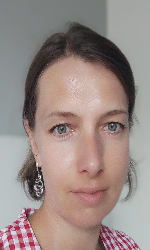

In [44]:
test_path = 'datasets/face_dataset_test_images/me/82.jpg'
test_image = image.load_img(test_path, target_size=(img_height, img_width, 3))
test_image

In [45]:
test_image = image.img_to_array(test_image)  # from image to array
# shape from (250, 150, 3) to (1, 250, 150, 3)
test_image = np.expand_dims(test_image, axis=0)
result = face_classifier.predict(test_image)

for index in range(num_classes):
    print("{:6} with probabily of {:.2f}%".format(
        class_names[index], result[0][index] * 100))

Not_me with probabily of 29.21%
me     with probabily of 94.26%
